In [2]:
import os
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, AveragePooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Add, Lambda, Concatenate
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, GlobalAveragePooling2D, Dense, Dense, Dropout, BatchNormalization

In [ ]:
# Check if GPU available
!nvidia-smi

Thu Oct 12 01:42:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Example usage:
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 16

In [4]:
def fire_module(x, s1x1, e1x1, e3x3):
    # Squeeze layer (1x1 convolution)
    squeeze = Conv2D(s1x1, (1, 1), padding='valid', activation='relu')(x)

    # Expand layer with 1x1 and 3x3 convolutions
    expand1x1 = Conv2D(e1x1, (1, 1), padding='valid', activation='relu')(squeeze)
    expand3x3 = Conv2D(e3x3, (3, 3), padding='same', activation='relu')(squeeze)

    # Concatenate the output of expand1x1 and expand3x3
    merged = concatenate([expand1x1, expand3x3], axis=-1)

    return merged

def squeezenet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Initial Convolution and MaxPooling
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='valid', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Fire Modules
    x = fire_module(x, 16, 64, 64)
    x = fire_module(x, 16, 64, 64)
    x = fire_module(x, 32, 128, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, 32, 128, 128)
    x = fire_module(x, 48, 192, 192)
    x = fire_module(x, 48, 192, 192)
    x = fire_module(x, 64, 256, 256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, 64, 256, 256)

    # Convolution and Average Pooling
    x = Conv2D(1000, (1, 1), padding='valid', activation='relu')(x)
    x = AveragePooling2D(pool_size=(13, 13))(x)

    # Flatten and Fully Connected Layer
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)
    return model

In [5]:
#create a model
model = squeezenet(input_shape, num_classes)

In [6]:
#Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 55, 55, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 55, 55, 16)           1040      ['max_pooling2d[0][0]']   

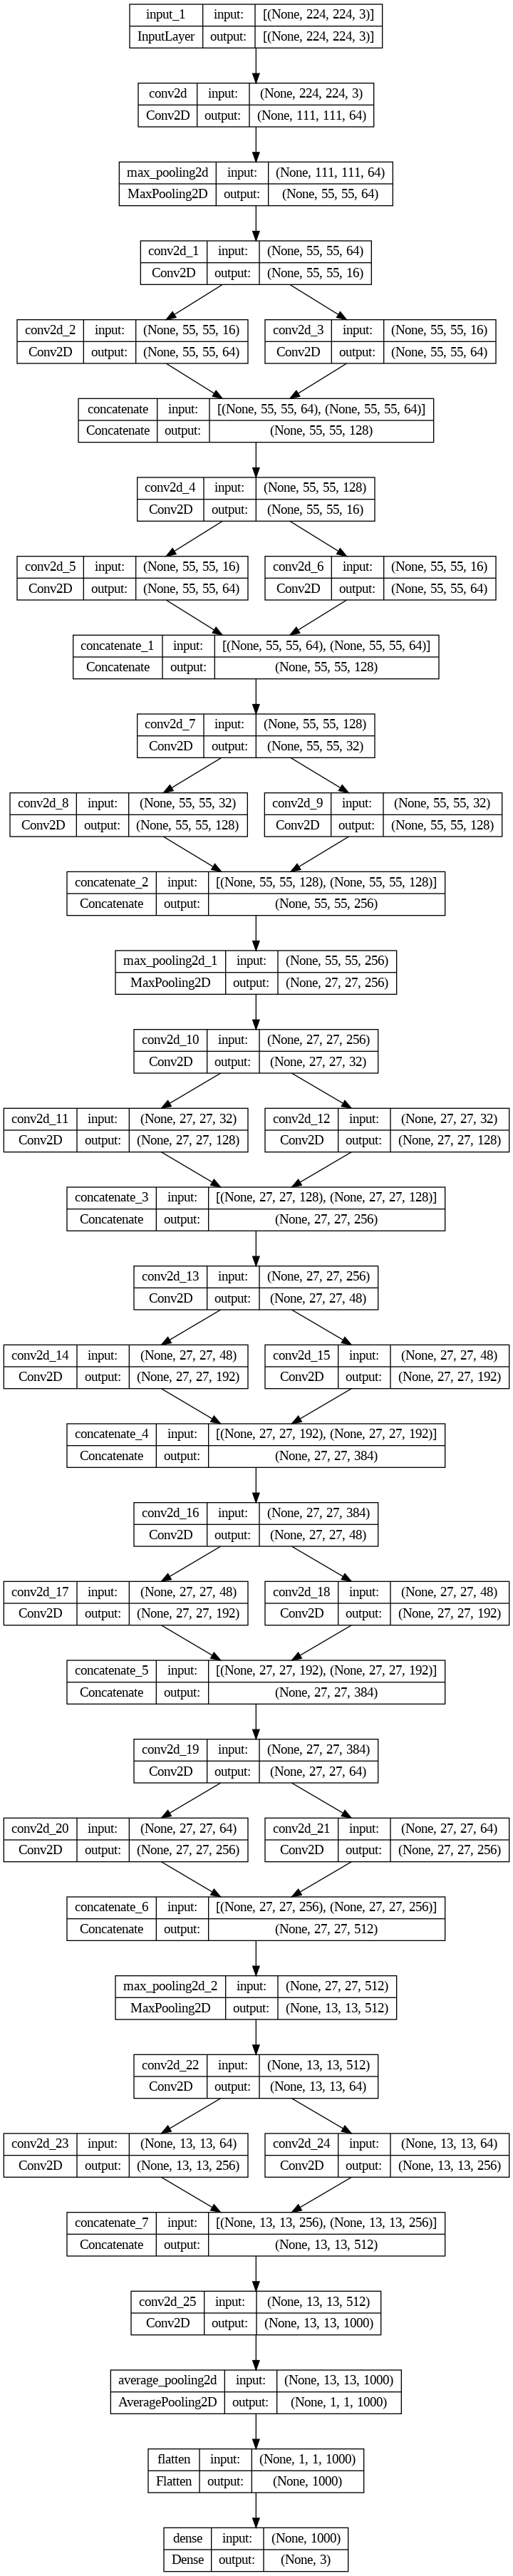

In [7]:
from tensorflow.keras.utils import plot_model
# Visualize the model architecture and save it to a file
plot_model(model, to_file='squeezenet.png', show_shapes=True)

In [8]:
# Define a function to load images and labels from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg"):  # Adjust file extension as needed
                img = cv2.imread(os.path.join(class_dir, filename))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, input_shape[:2])  # Resize to the desired input shape
                label = class_names.index(class_name)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [9]:
# Load train, validation, and test data
train_images, train_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/train')
validation_images, validation_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/val')
test_images, test_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/test')

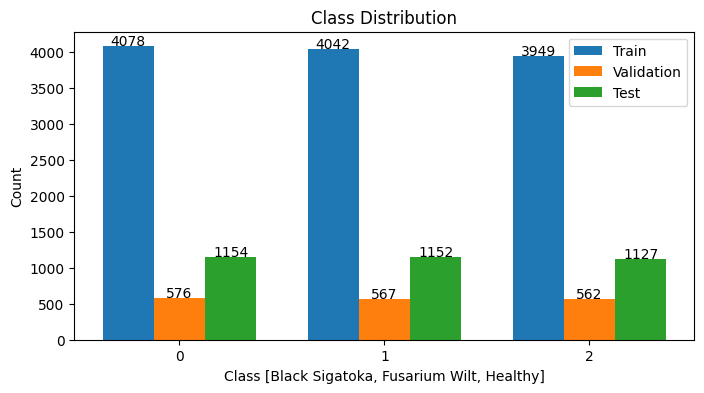

In [10]:
#Counting and ploting the distribution of the classes
def plot_class_distribution(train_labels, validation_labels, test_labels):
    # Calculate class counts for each set
    train_class_counts = np.bincount(train_labels)
    validation_class_counts = np.bincount(validation_labels)
    test_class_counts = np.bincount(test_labels)

    # Get the number of unique classes
    num_classes = len(train_class_counts)

    # Generate class labels (class names)
    class_labels = [str(i) for i in range(num_classes)]

    # Create a bar chart to display class distribution
    x = np.arange(num_classes)  # x-axis values
    width = 0.25  # Width of bars

    plt.figure(figsize=(8, 4))
    plt.bar(x - width, train_class_counts, width, label='Train')
    plt.bar(x, validation_class_counts, width, label='Validation')
    plt.bar(x + width, test_class_counts, width, label='Test')

    plt.xlabel('Class [Black Sigatoka, Fusarium Wilt, Healthy]')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.xticks(x, class_labels)

    # Add labels above the bars
    for i in range(num_classes):
        plt.text(x[i] - width, train_class_counts[i] + 10, str(train_class_counts[i]), ha='center')
        plt.text(x[i], validation_class_counts[i] + 10, str(validation_class_counts[i]), ha='center')
        plt.text(x[i] + width, test_class_counts[i] + 10, str(test_class_counts[i]), ha='center')

    plt.legend()
    plt.show()
# Usage
plot_class_distribution(train_labels, validation_labels, test_labels)

In [11]:
# One-hot encode the class labels
train_labels_onehot = to_categorical(train_labels, num_classes=num_classes)
validation_labels_onehot = to_categorical(validation_labels, num_classes=num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes=num_classes)

In [12]:
# Define data generators for train, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/train',  # Replace with the path to your train data directory
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True

)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/val',  # Replace with the path to your train data directory
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False

)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/test',  # Replace with the path to your test data directory
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12069 images belonging to 3 classes.
Found 1705 images belonging to 3 classes.
Found 3433 images belonging to 3 classes.


In [13]:
# Create optimizer with custom parameters
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005, momentum=0.9, name='RMSprop')

# Compile
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
# Define the early stopping and learning rate reduction callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

In [15]:
# Train the model
import time
start_time = time.time()
epochs = 100
history = model.fit(train_images,train_labels_onehot, batch_size=batch_size,epochs=epochs,
                    validation_data=(validation_images, validation_labels_onehot), callbacks=[early_stopping]
)
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/100
755/755 [==============================] - 50s 45ms/step - loss: 0.6586 - accuracy: 0.6754 - val_loss: 0.3862 - val_accuracy: 0.8551
Epoch 2/100
755/755 [==============================] - 31s 41ms/step - loss: 0.3608 - accuracy: 0.8562 - val_loss: 0.3393 - val_accuracy: 0.8674
Epoch 3/100
755/755 [==============================] - 31s 41ms/step - loss: 0.2857 - accuracy: 0.8940 - val_loss: 0.1821 - val_accuracy: 0.9308
Epoch 4/100
755/755 [==============================] - 31s 41ms/step - loss: 0.2532 - accuracy: 0.9060 - val_loss: 0.2095 - val_accuracy: 0.9220
Epoch 5/100
755/755 [==============================] - 31s 41ms/step - loss: 0.2091 - accuracy: 0.9265 - val_loss: 0.2025 - val_accuracy: 0.9326
Epoch 6/100
755/755 [==============================] - 31s 41ms/step - loss: 0.1925 - accuracy: 0.9308 - val_loss: 0.1989 - val_accuracy: 0.9243
Epoch 7/100
755/755 [==============================] - 31s 41ms/step - loss: 0.1692 - accuracy: 0.9413 - val_loss: 0.2226 - val_ac

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_onehot)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

108/108 [==============================] - 4s 25ms/step - loss: 0.0969 - accuracy: 0.9712
Test Loss: 0.0969
Test Accuracy: 0.9712


In [17]:
# Generate confusion matrix
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

108/108 [==============================] - 3s 24ms/step


In [18]:
# Generate classification report
class_labels = sorted(os.listdir('/content/drive/MyDrive/Training/Data/Data_file/test'))  # Get class names from the test directory
report = classification_report(test_labels, predicted_labels, target_names=class_labels)
print(report)

                precision    recall  f1-score   support

BLACK_SIGATOKA       0.98      0.96      0.97      1154
 FUSARIUM_WILT       0.95      0.97      0.96      1152
       HEALTHY       0.98      0.98      0.98      1127

      accuracy                           0.97      3433
     macro avg       0.97      0.97      0.97      3433
  weighted avg       0.97      0.97      0.97      3433



In [19]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

# Calculate precision
precision = precision_score(test_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(test_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9711622487620157
Precision: 0.9713551533856639
Recall: 0.9711622487620157
F1-score: 0.971202289242897


108/108 [==============================] - 3s 24ms/step


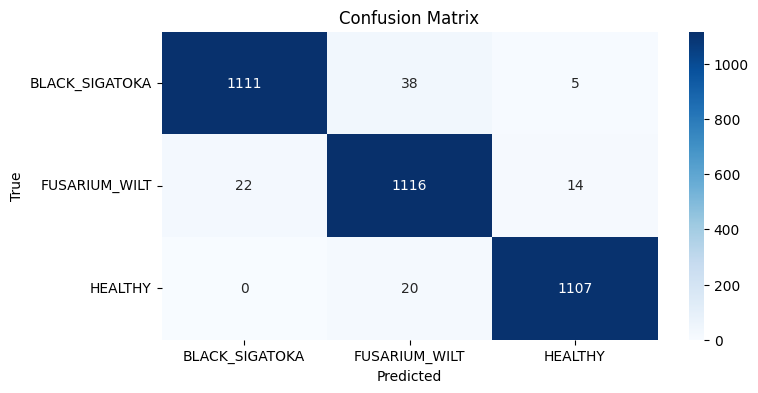

In [20]:
confusion_mtx = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True') # Generate confusion matrix
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)
plt.title('Confusion Matrix')
plt.show()

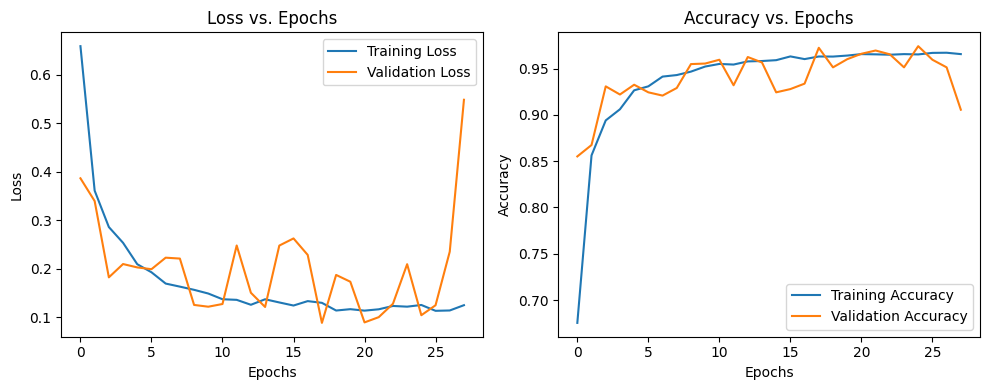

In [21]:
#Plot loss graphs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()